### Dataset
We'll continue using the same 1994 census data set on U.S. income. It contains information on marital status, age, type of work, and more. The target column, high_income, records salaries less than or equal to 50k a year (0), and more than 50k a year (1).


In [3]:
import pandas as pd
income = pd.read_csv('income.csv')

In [4]:
income.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,high_income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
income.shape

(32561, 15)

### Converting the categorical variables to numeric variables

In [6]:
categorical_cols = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country', 'high_income']
for cat in categorical_cols:
    income[cat] = pd.Categorical(income[cat]).codes

### Splitting our data into training and testing sets

In [7]:
import numpy as np
np.random.seed(1)
income = income.reindex(np.random.permutation(income.index))

In [8]:
import math
split_rows = math.floor(0.8 * income.shape[0])

train = income.iloc[:split_rows]
test = income.iloc[split_rows:]

In [9]:
train.shape
test.shape

(26048, 15)

(6513, 15)

### Combining Model Predictions With Ensembles
A random forest is a kind of ensemble model. [Ensembles](https://en.wikipedia.org/wiki/Ensemble_learning) combine the predictions of multiple models to create a more accurate final prediction. We'll make a simple ensemble to see how they work.

### Using multiple classifiers to make predictions

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

columns = ["age", "workclass", "education_num", "marital_status", "occupation", "relationship", "race", "sex", "hours_per_week", "native_country"]

# Tree with min_samples_leaf set to 2
clf = DecisionTreeClassifier(random_state=1, min_samples_leaf=2)
clf.fit(train[columns], train["high_income"])

# Tree with max_depth set to 5
clf2 = DecisionTreeClassifier(random_state=1, max_depth=5)
clf2.fit(train[columns], train["high_income"])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

Accuracy from prediction 1:  0.6878964226062301
Accuracy from prediction 2: 0.6759853906508785


In [14]:
predictions = clf.predict(test[columns])
print("Accuracy from prediction 1: ", roc_auc_score(test["high_income"], predictions))

Accuracy from prediction 1:  0.6766364169835877


In [15]:
predictions = clf2.predict(test[columns])
print("Accuracy from prediction 2:",  roc_auc_score(test["high_income"], predictions))

Accuracy from prediction 2: 0.6759853906508785


### Combining Our Predictions


In [17]:
import numpy
predictions = clf.predict_proba(test[columns])[:,1]
predictions2 = clf2.predict_proba(test[columns])[:,1]

combined = (predictions + predictions2) / 2
rounded = numpy.round(combined)

print("Average accuracy from two predictions :", roc_auc_score(test["high_income"], rounded))

Average accuracy from two predictions : 0.7075968440037425


### Introducing Variation With Bagging
A random forest is an ensemble of decision trees. Without any modifications to the trees, each tree will be exactly the same, so we'll get no boost when we ensemble them. In order to make ensembling effective, we have to introduce variation into each individual decision tree model.

If we introduce variation, each tree will be be constructed slightly differently, and will therefore make different predictions. This variation is what puts the "random" in "random forest."

There are two main ways to introduce variation in a random forest:
- bagging 
- and random feature subsets.

We'll dive into bagging first.

In [13]:
"Average accuracy from two predictions :", # We'll build 10 trees
tree_count = 10

# Each "bag" will have 60% of the number of original rows
bag_proportion = .6

predictions = []
for i in range(tree_count):
    # We select 60% of the rows from train, sampling with replacement
    # We set a random state to ensure we'll be able to replicate our results
    # We set it to i instead of a fixed value so we don't get the same sample in every loop
    # That would make all of our trees the same
    bag = train.sample(frac=bag_proportion, replace=True, random_state=i)
    
    # Fit a decision tree model to the "bag"
    clf = DecisionTreeClassifier(random_state=1, min_samples_leaf=2)
    clf.fit(bag[columns], bag["high_income"])
    
    # Using the model, make predictions on the test data
    predictions.append(clf.predict_proba(test[columns])[:,1])

    
combined = numpy.sum(predictions, axis=0) / 10
rounded = numpy.round(combined)

print("Average accuracy from two predictions after bagging:", roc_auc_score(test["high_income"], rounded))

('Average accuracy from two predictions :',)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

Average accuracy from two predictions after bagging: 0.7329963297474371


### Selecting Random Features
Using the bagging example, we gained some accuracy over a single decision tree. To be exact, we achieved an AUC score of around `.733` with bagging, which is an improvement over the AUC score of `.688` we got without bagging:
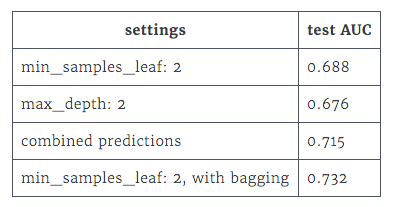
Let's go back to the decision tree algorithm we explored two missions ago to explain random feature subsets:

- First we pick the maximum number of features we want to evaluate each time we split the tree.
    - This has to be less than the total number of columns in the data.
- Every time we split, we pick a random sample of features from the data.
- Then we compute the information gain for each feature in our random sample, and pick the one with the highest information gain to split on.


### Implementing ID3 algorithm with a subset of the features

In [22]:
def calc_entropy(column):
    probabilities = np.bincount(column) / len(column)
    
    entropy = 0
    for prob in probabilities:
        if prob > 0:
            entropy += prob * math.log(prob, 2)
    
    return -entropy

In [23]:
def calc_information_gain(data, split_name, target_name):
    original_entropy = calc_entropy(data[target_name])
    
    column = data[split_name]
    
    left = data[column <= column.median()]
    right = data[column > column.median()]
    
    to_subtract = 0
    for subset in [left, right]:
        prob = (subset.shape[0] / data.shape[0]) 
        to_subtract += prob * calc_entropy(subset[target_name])
    
    return original_entropy - to_subtract

In [26]:
tree = {}
nodes = []
np.random.seed(1)

def find_best_column(data, target_name, columns):
    information_gains = []
    
    cols = np.random.choice(columns, 2)
    
    for col in columns:
        information_gain = calc_information_gain(data, col, "high_income")
        information_gains.append(information_gain)
        
    highest_gain_index = information_gains.index(max(information_gains))
    highest_gain = columns[highest_gain_index]
    return highest_gain

In [27]:
def id3(data, target, columns, tree):
    unique_targets = pd.unique(data[target])
    nodes.append(len(nodes) + 1)
    tree["number"] = nodes[-1]

    if len(unique_targets) == 1:
        if 0 in unique_targets:
            tree["label"] = 0
        elif 1 in unique_targets:
            tree["label"] = 1
        return
    best_column = find_best_column(data, target, columns)
    column_median = data[best_column].median()
    
    tree["column"] = best_column
    tree["median"] = column_median
    
    left_split = data[data[best_column] <= column_median]
    right_split = data[data[best_column] > column_median]
    split_dict = [["left", left_split], ["right", right_split]]
    
    for name, split in split_dict:
        tree[name] = {}
        id3(split, target, columns, tree[name])

In [28]:
data = pd.DataFrame([
    [0,4,20,0],
    [0,4,60,2],
    [0,5,40,1],
    [1,4,25,1],
    [1,5,35,2],
    [1,5,55,1]
    ])

data.columns = ["high_income", "employment", "age", "marital_status"]

In [29]:
id3(data, "high_income", ["employment", "age", "marital_status"], tree)

In [30]:
tree

{'number': 1,
 'column': 'employment',
 'median': 4.5,
 'left': {'number': 2,
  'column': 'age',
  'median': 25.0,
  'left': {'number': 3,
   'column': 'age',
   'median': 22.5,
   'left': {'number': 4, 'label': 0},
   'right': {'number': 5, 'label': 1}},
  'right': {'number': 6, 'label': 0}},
 'right': {'number': 7,
  'column': 'age',
  'median': 40.0,
  'left': {'number': 8,
   'column': 'age',
   'median': 37.5,
   'left': {'number': 9, 'label': 1},
   'right': {'number': 10, 'label': 0}},
  'right': {'number': 11, 'label': 1}}}

### another approach

In [31]:
import pandas
# Create the data set that we used two missions ago
data = pandas.DataFrame([
    [0,4,20,0],
    [0,4,60,2],
    [0,5,40,1],
    [1,4,25,1],
    [1,5,35,2],
    [1,5,55,1]
    ])
data.columns = ["high_income", "employment", "age", "marital_status"]

# Set a random seed to make the results reproducible
numpy.random.seed(1)

# The dictionary to store our tree
tree = {}
nodes = []


def find_best_column(data, target_name, columns):
    information_gains = []
    
    # Select two columns randomly
    cols = numpy.random.choice(columns, 2)
    
    for col in cols:
        information_gain = calc_information_gain(data, col, "high_income")
        information_gains.append(information_gain)

    highest_gain_index = information_gains.index(max(information_gains))
    
    # Get the highest gain by indexing "cols"
    highest_gain = cols[highest_gain_index]
    
    return highest_gain

# The function to construct an ID3 decision tree
def id3(data, target, columns, tree):
    unique_targets = pandas.unique(data[target])
    nodes.append(len(nodes) + 1)
    tree["number"] = nodes[-1]

    if len(unique_targets) == 1:
        if 0 in unique_targets:
            tree["label"] = 0
        elif 1 in unique_targets:
            tree["label"] = 1
        return
    
    best_column = find_best_column(data, target, columns)
    column_median = data[best_column].median()
    
    tree["column"] = best_column
    tree["median"] = column_median
    
    left_split = data[data[best_column] <= column_median]
    right_split = data[data[best_column] > column_median]
    split_dict = [["left", left_split], ["right", right_split]]
    
    for name, split in split_dict:
        tree[name] = {}
        id3(split, target, columns, tree[name])


# Run the ID3 algorithm on our data set and print the resulting tree
id3(data, "high_income", ["employment", "age", "marital_status"], tree)
print(tree)

{'number': 1, 'column': 'age', 'median': 37.5, 'left': {'number': 2, 'column': 'employment', 'median': 4.0, 'left': {'number': 3, 'column': 'age', 'median': 22.5, 'left': {'number': 4, 'label': 0}, 'right': {'number': 5, 'label': 1}}, 'right': {'number': 6, 'label': 1}}, 'right': {'number': 7, 'column': 'age', 'median': 55.0, 'left': {'number': 8, 'column': 'age', 'median': 47.5, 'left': {'number': 9, 'label': 0}, 'right': {'number': 10, 'label': 1}}, 'right': {'number': 11, 'label': 0}}}


### Random Subsets in scikit-learn
We can also repeat our random subset selection process in scikit-learn. We just set the splitter parameter on DecisionTreeClassifier to "random", and the max_features parameter to "auto". If we have N columns, this will pick a subset of features of size $\sqrt(N)$, compute the Gini coefficient for each (this is similar to information gain), and split the node on the best column in the subset.

This is essentially the same thing we did on the previous screen, but with far less typing.

**Instructions**

- Modify the instantiation of the DecisionTreeClassifier object.

 - Set splitter to "random", and max_features to "auto".
- Print the resulting AUC score.

In [ ]:
# We'll build 10 trees
tree_count = 10

# Each "bag" will have 60% of the number of original rows
bag_proportion = .6

predictions = []
for i in range(tree_count):
    # We select 60% of the rows from train, sampling with replacement
    # We set a random state to ensure we'll be able to replicate our results
    # We set it to i instead of a fixed value so we don't get the same sample every time
    bag = train.sample(frac=bag_proportion, replace=True, random_state=i)
    
    # Fit a decision tree model to the "bag"
    clf = DecisionTreeClassifier(random_state=1, min_samples_leaf=2, splitter="random", max_features="auto")
    clf.fit(bag[columns], bag["high_income"])
    
    # Using the model, make predictions on the test data
    predictions.append(clf.predict_proba(test[columns])[:,1])

combined = numpy.sum(predictions, axis=0) / 10
rounded = numpy.round(combined)

print(roc_auc_score(test["high_income"], rounded))